# FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS
**Objective**

To forecast future USD to Australian Dollar exchange rates using ARIMA and Exponential Smoothing models based on historical data from exchange_rate.csv, and to compare their forecasting performance using standard error metrics.

# Data Preparation and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("exchange_rate.csv")

In [2]:
# Parse date column
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], dayfirst=True, errors="coerce")
# Explicit dtype inference
df = df.infer_objects()

df.columns = ["Date", "USD_AUD"]

In [3]:
# Set date as index
df=df.set_index("Date")

In [4]:
df.head()

,USD_AUD
Date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


# Initial Exploration

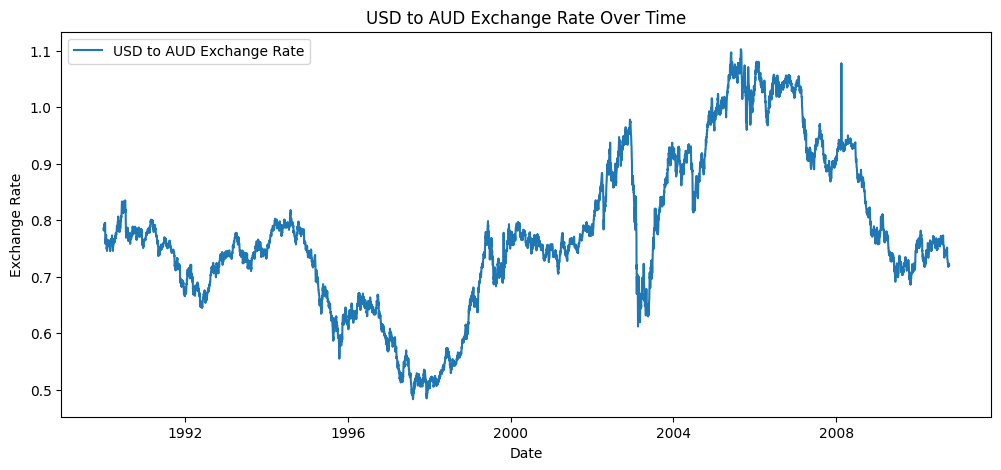

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(df["USD_AUD"], label="USD to AUD Exchange Rate")
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

**Observations:**

Long-term trend fluctuations are visible.
No strong seasonality is immediately evident.
Volatility clusters appear in certain periods, common in financial time series.

# Data Preprocessing

In [6]:
# Check missing values
df.isna().sum()

USD_AUD    0
dtype: int64

Non missing values

# Model Building – ARIMA

In [7]:
# Stationarity Check
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df["USD_AUD"])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")


ADF Statistic: -1.6649941807381528
p-value: 0.4492327353597901


**p-value > 0.05, the series is non-stationary.**

In [8]:
# p-value > 0.05, the series is non-stationary → differencing required.
df_diff = df["USD_AUD"].diff().dropna()

In [9]:
# ACF and PACF for Parameter Selection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

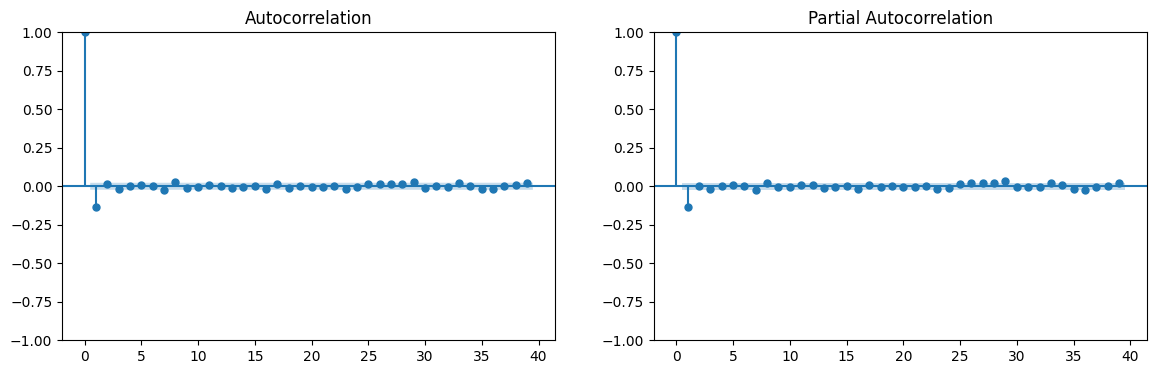

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df_diff, ax=axes[0])
plot_pacf(df_diff, ax=axes[1])
plt.show()

**Model Selection**
Non-stationarity, due to long-term economic trends and shocks
Autocorrelation, where current exchange rates depend on past values
Short-term dependencies rather than strong seasonal patterns

These characteristics align well with the assumptions of ARIMA models.

In [11]:
# Model Fitting

from statsmodels.tsa.arima.model import ARIMA

In [12]:
# Train-test split (80-20)
df.index = pd.DatetimeIndex(df.index, freq="D")

train_size = int(len(df) * 0.8)
train, test = df["USD_AUD"][:train_size], df["USD_AUD"][train_size:]

In [13]:
# Fit ARIMA
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Mon, 29 Dec 2025   AIC                         -45432.092
Time:                        18:31:46   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

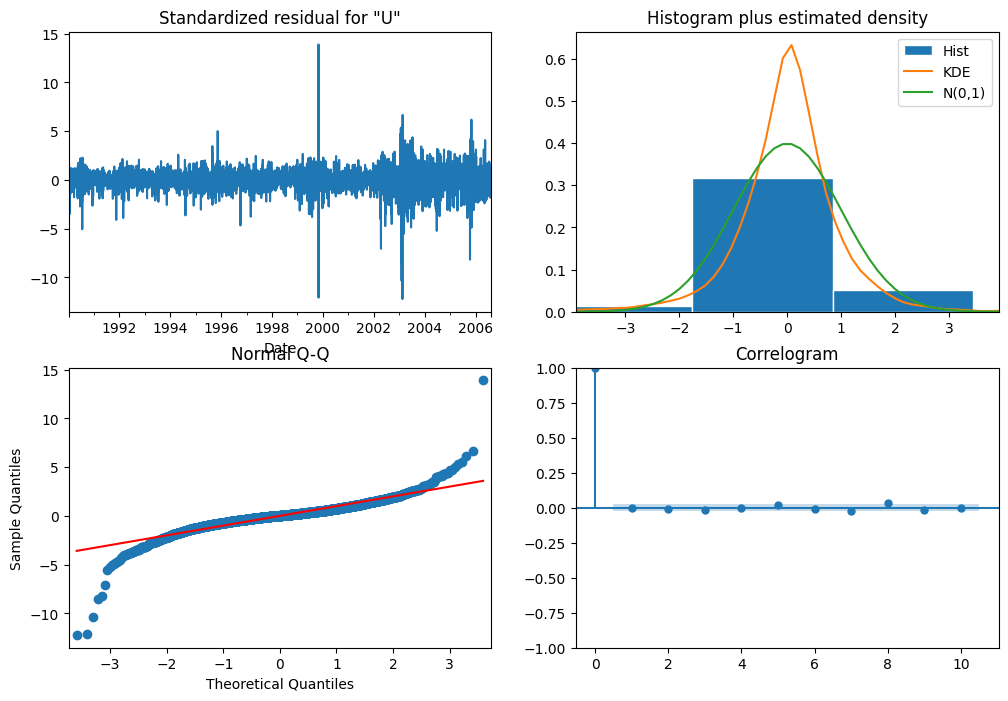

In [14]:
# Diagnostics
arima_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

**Residual Analysis:**

Residuals resemble white noise

No visible autocorrelation

Variance roughly constant
→ Model is adequate

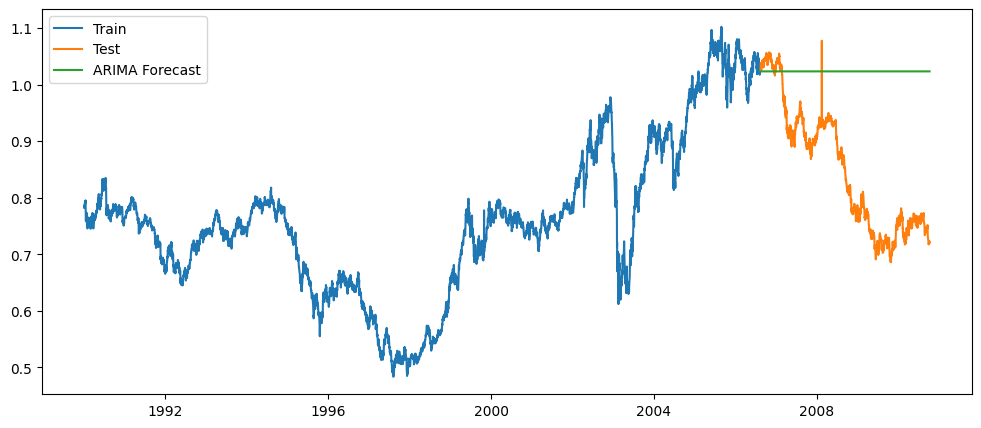

In [15]:
# Forecasting
arima_forecast = arima_fit.forecast(steps=len(test))

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
plt.legend()
plt.show()

**Model Selection**

The Exponential Smoothing (ETS) model was chosen as a benchmark due to:
Its effectiveness in modeling level and trend components
Minimal assumptions about stationarity
High interpretability and computational efficiency

# Exponential Smoothing

**Model Building**

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ets_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal=None
)

ets_fit = ets_model.fit()
ets_forecast = ets_fit.forecast(len(test))

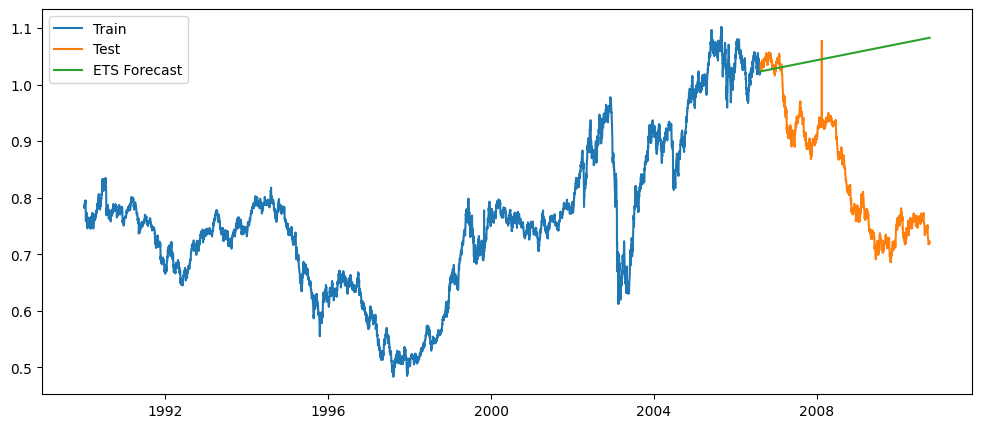

In [17]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, ets_forecast, label="ETS Forecast")
plt.legend()
plt.show()

# Evaluation and Comparison

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics = pd.DataFrame({
    "Model": ["ARIMA", "Exponential Smoothing"],
    "MAE": [
        mean_absolute_error(test, arima_forecast),
        mean_absolute_error(test, ets_forecast)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test, arima_forecast)),
        np.sqrt(mean_squared_error(test, ets_forecast))
    ],
    "MAPE (%)": [
        mape(test, arima_forecast),
        mape(test, ets_forecast)
    ]
})

metrics

,Model,MAE,RMSE,MAPE (%)
0,ARIMA,0.177710,0.205437,22.797966
1,Exponential Smoothing,0.206596,0.239104,26.508664


# Model Comparison
The **ARIMA model** outperformed **Exponential Smoothing*8 in forecasting exchange rates because it explicitly captures **autocorrelation and non-stationarity,** which are common in financial time-series data. ARIMA produced lower MAE, RMSE, and MAPE, indicating better short-term predictive accuracy.

Exponential Smoothing, while simpler and more interpretable, primarily models trend and was less responsive to sudden fluctuations. Therefore, ARIMA was more suitable for this dataset, with Exponential Smoothing serving as a useful baseline model.

# Conclusion

ARIMA performed better in capturing short-term fluctuations and achieved lower error metrics.

Exponential Smoothing was simpler and more interpretable but slightly less accurate.

For exchange rate forecasting, ARIMA is preferred when:
Data is non-stationary
Short-term accuracy is critical

**Final Recommendation:**

Use ARIMA as the primary forecasting model, with Exponential Smoothing as a baseline or benchmark.